In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt



In [2]:
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TEST.ts")
y_train=np.array(y_train,'float')
y_test=np.array(y_test,'float')



In [3]:
def df_to_np(X):
    return np.stack([
        np.stack(row.values)  # stack channels
        for _, row in X.iterrows()  # iterate over samples
    ])


In [4]:
X_train_tmp_np=df_to_np(X_train)
X_test_tmp_np=df_to_np(X_test)

#y_train_np=df_to_np(y_train)

In [5]:
X_train_tmp_np0=X_train_tmp_np#[:,0:2,:]
X_test_tmp_np0=X_test_tmp_np#[:,0:2,:]

In [6]:
def preprocess_ppg(signal, clip_range=(-100, 100)):
    # 1. Clip outliers
    clipped = np.clip(signal, clip_range[0], clip_range[1])
    
    # 2. Normalize: zero mean, unit variance
    mean = clipped.mean()
    std = clipped.std()
    if std == 0:
        std = 1  # avoid division by zero
    normalized = (clipped - mean) / std
    
    return normalized

In [7]:
def preprocess_mat(X):
    shape=X.shape
    plot=False
    nu_samples=shape[0]
    nu_features=shape[1]
    for fea in range(nu_features):
        for i in range(nu_samples):
            if np.mod(i,1000)==0:
                print(i)
            preprocessed=preprocess_ppg(X[i,fea,:])
            X[i,fea,:]=preprocessed
            if plot==True:
                fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
                axes[0].plot(preprocessed)   
                axes[1].plot(X_train_tmp_np[i,0,:])
                plt.show()
                input('a')
    return X
    

In [8]:
X_train_tmp_np=preprocess_mat(X_train_tmp_np0)
X_test_tmp_np=preprocess_mat(X_test_tmp_np0)

0
1000
0
1000
0
1000
0
1000
0
1000
0
1000
0
1000
0
1000
0
1000
0
1000


In [9]:
#print(X_train_np.shape)
#print("X np start", X_train_np[0,0,:5])
def make_batches(X_np):
    shape=X_np.shape
    nu_time_steps=shape[2]
    nu_features=shape[1]
    nu_samples=shape[0]
    batch_size=1000
    assert np.mod(nu_time_steps*nu_samples,batch_size)==0
    nu_batches=int(nu_time_steps*nu_samples/batch_size)
    X_np_new=X_np.reshape(nu_batches,nu_features,batch_size)
    return X_np_new

X_train_np=make_batches(X_train_tmp_np)
X_test_np=make_batches(X_test_tmp_np)

#print(X_np_new.shape)
#print("X np new start", X_np_new[0,0,:5])
print(X_train_np[1,0,:10])
#print(X_np_new[10,0,:5])


[-0.79854698 -0.7104687  -0.76918755 -0.73982813 -0.79854698 -0.68110928
 -0.7104687  -0.76918755 -0.68110928 -0.76918755]


In [10]:
def make_batch_target(y):
    y_out=[]
    for item in y:
        for i in range(1):
            y_out.append(item)
    return np.array(y_out,'float')
    
y_train_np=make_batch_target(y_train)
y_test_np=make_batch_target(y_test)

In [11]:
print(X_train_np.shape)
print(y_train_np.shape)
print(X_test_np.shape)
print(y_test_np.shape)

(1768, 5, 1000)
(1768,)
(1328, 5, 1000)
(1328,)


In [12]:
# Train/test split
#n_samples = 1000

#split = int(0.8 * n_samples)
#X_train, X_test = X[:split], X[split:n_samples]
#y_train, y_test = y[:split], y[split:n_samples]
# Convert X_train DataFrame to a NumPy array
#X_train_np = np.array([row.values for _, row in X_train.iterrows()])
#y_train_np = np.array(y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [13]:
def torch_plotter(output_tensor):
    channel_to_plot = output_tensor[0, 0, :].detach().numpy()  # Detach from the graph to avoid tracking gradients
    
    # Plotting the first channel's output over time steps
    plt.plot(channel_to_plot)
    plt.title("Output of Conv1D - First Channel")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.show()

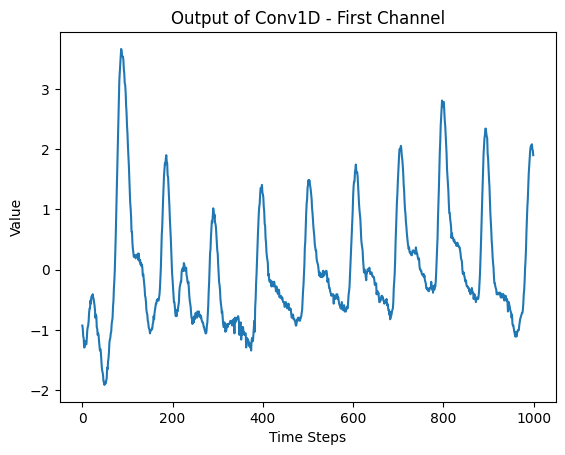

In [14]:
torch_plotter(X_train_tensor)

In [15]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=30, kernel_size=100, padding=5)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(30, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [16]:
class PPGTransformer(nn.Module):
    def __init__(self, seq_len=1000, n_channels=5, d_model=64, nhead=4, num_layers=2):
        super(PPGTransformer, self).__init__()
        
        self.input_proj = nn.Linear(n_channels, d_model)  # [B, 100, 3] -> [B, 100, 64]
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, C, T] --> permute to [B, T, C] for transformer
        x = x.permute(0, 2, 1)  # [B, 100, 3]
        x = self.input_proj(x)  # [B, 100, 64]
        x = self.transformer(x)  # [B, 100, 64]
        x = x.mean(dim=1)        # Global average pooling over sequence: [B, 64]
        x = self.regressor(x)    # [B, 1]
        return x

In [ ]:
# 3. Train the model
#model = PPGCNN()
model = PPGTransformer()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        #print(xb.shape)
        #input('a')
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")





Epoch 1/20, Loss: 1002394.85
Epoch 2/20, Loss: 965515.68
Epoch 3/20, Loss: 926795.10
Epoch 4/20, Loss: 881738.81
Epoch 5/20, Loss: 837281.11
Epoch 6/20, Loss: 785262.53
Epoch 7/20, Loss: 729069.91
Epoch 8/20, Loss: 677311.20
Epoch 9/20, Loss: 623743.47
Epoch 10/20, Loss: 566394.42
Epoch 11/20, Loss: 511283.29
Epoch 12/20, Loss: 460506.59
Epoch 13/20, Loss: 407637.90
Epoch 14/20, Loss: 359298.81
Epoch 15/20, Loss: 315038.55
Epoch 16/20, Loss: 270899.50
Epoch 17/20, Loss: 232929.85
Epoch 18/20, Loss: 198709.91
Epoch 19/20, Loss: 169907.47
Epoch 20/20, Loss: 141932.63


In [ ]:
# 4. Evaluate

# Evaluate in batches
model.eval()
preds = []
targets = []

#with torch.no_grad():
#    preds = model(X_test_tensor).squeeze().numpy()
#    targets = y_test_tensor.squeeze().numpy()
#    mae = np.mean(np.abs(preds - targets))
#    print(f"\nTest MAE: {mae:.2f} bpm")

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb).squeeze().numpy()
        preds.append(pred)
        targets.append(yb.squeeze().numpy())

# Concatenate predictions and targets
preds = np.concatenate(preds)
targets = np.concatenate(targets)
mae = np.mean(np.abs(preds - targets))
print(f"\nTest MAE: {mae:.2f} bpm")

In [1]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets, label="True HR")
plt.plot(preds, label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot
plt.figure(figsize=(10, 4))

# 6. Plot PPG data
for i in range(100):
    if np.max(np.abs(X_train_np[i,0,:]))>200:
        plt.plot(X_train_np[i,0,:], label="PPG Signal")  # Assuming X is your input PPG data
        plt.title("PPG Signal for Sample 0")
        plt.xlabel("Sample Index")
        plt.ylabel("PPG Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()  # Display the second plot
        print(i)
        input('a')

NameError: name 'plt' is not defined